In [81]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
import statsmodels.api as sm
import math
import matplotlib.pyplot as plt

In [23]:
def clean_fundamentals(fundamentals):
    fundamentals = fundamentals[(fundamentals["exchg"]>=11) & (fundamentals["exchg"]<=19)]
    fundamentals = fundamentals[fundamentals["curcd"] == "USD"]
    fundamentals = fundamentals[fundamentals["indfmt"] == "INDL"]
    fundamentals = fundamentals[fundamentals["fic"] == "USA"]
    fundamentals = fundamentals[(fundamentals["sic"] <= 5999) | (fundamentals["sic"] >= 7000)]

    fundamentals['datadate'] = pd.to_datetime(fundamentals['datadate'])

    fundamentals['datadate'] = fundamentals['datadate'] + pd.DateOffset(months=3)

    fundamentals['year'] = fundamentals['datadate'].dt.year

    fundamentals['xrd'] = fundamentals['xrd'].fillna(0)

    fundamentals = fundamentals.sort_values(by=['datadate','LPERMNO']).reset_index(drop=True)

    return fundamentals

In [24]:
def clean_stocks(stocks_input):
    
    stocks = stocks_input.copy()
    stocks = stocks[pd.to_numeric(stocks['RET'], errors='coerce').notnull()]

    stocks['RET'] = pd.to_numeric(stocks['RET'])

    stocks["date"] = pd.to_datetime(stocks["date"])

    stocks = stocks[(stocks["RET"] < 500)]

    stocks = stocks[(stocks["RET"] > -100)]

    stocks = stocks[(stocks["SHROUT"] > 0)]

    stocks["PRC"] = abs(stocks["PRC"])

    stocks["PRC"] = stocks["PRC"].replace({0:np.nan})

    stocks["SHROUT"] = stocks["SHROUT"].fillna(method="ffill")

    stocks = stocks.dropna(subset=["SHROUT", "PRC"])

    stocks["Market Cap"] = stocks["PRC"] * stocks["SHROUT"]

    stocks.rename({"date": "datadate", "PERMNO":"LPERMNO"}, axis=1, inplace=True)

    stocks['datadate'] = stocks['datadate'] + MonthEnd(0)

    stocks["year"] = [i.year if i >= pd.Timestamp(year=i.year, month=4, day=1) else i.year-1 for i in stocks["datadate"]]

    return stocks

In [25]:
def get_rd_capital(fundamentals):

    weights = np.array([0.2, 0.4, 0.6, 0.8, 1.0])

    rd_cap = fundamentals.groupby("LPERMNO")["xrd"].rolling(5).apply(lambda x: np.sum(weights*x)).reset_index(level=[0,1])[["level_1", "xrd"]].set_index('level_1').rename(columns={"xrd": "RDC"})

    fundamentals = pd.merge(fundamentals, rd_cap, left_index=True, right_index=True)

    fundamentals = fundamentals.dropna(subset=['RDC'])
    fundamentals = fundamentals[["LPERMNO", "datadate", "RDC"]]

    return fundamentals

In [26]:
def split_rd_firms(fundamentals):
    
    non_rd_firms_fund = fundamentals[fundamentals["RDC"] == 0].copy()
    rd_firms_fund = fundamentals[fundamentals["RDC"] > 0].copy()

    rd_firms_fund["datadate"] = [pd.Timestamp(year=i.year+1,month=3, day=31) if i > pd.Timestamp(year=i.year, month=4, day=1) else pd.Timestamp(year=i.year,month=3, day=31)  for i in rd_firms_fund["datadate"]]
    non_rd_firms_fund["datadate"] = [pd.Timestamp(year=i.year+1,month=3, day=31) if i > pd.Timestamp(year=i.year, month=4, day=1) else pd.Timestamp(year=i.year,month=3, day=31)  for i in non_rd_firms_fund["datadate"]]

    return rd_firms_fund, non_rd_firms_fund

In [27]:
def merge_stock_fundamentals(rd_firms_fund, non_rd_firms_fund, stocks):
    rd_firms = pd.merge(stocks[["datadate", "Market Cap", "LPERMNO"]], rd_firms_fund, on = ["LPERMNO", "datadate"], how="right")
    non_rd_firms = pd.merge(stocks[["datadate", "Market Cap", "LPERMNO"]], non_rd_firms_fund, on = ["LPERMNO", "datadate"], how="right")

    rd_firms.dropna(inplace=True)
    non_rd_firms.dropna(inplace=True)
    
    return rd_firms, non_rd_firms


In [28]:
def remove_top_1000(rd_firms_in, non_rd_firms_in):

        rd_firms_in['id'] = ["rd-"+str(i) for i in range(rd_firms_in.shape[0])]
        non_rd_firms_in['id'] = ["nonrd-"+str(i) for i in range(non_rd_firms_in.shape[0])]
        firms = pd.concat([rd_firms_in, non_rd_firms_in])
        
        temp_1 = firms.reset_index(drop=True).sort_values('Market Cap',ascending = False)
        temp_2 = temp_1.groupby("year").head(1000).sort_values("year") 

        top_firms = temp_1[temp_1.index.isin(temp_2.index)]

        removed_top_rd = rd_firms_in[~rd_firms_in["id"].isin(top_firms["id"])]
        
        removed_top_non_rd = non_rd_firms_in[~non_rd_firms_in["id"].isin(top_firms["id"])]   


        return removed_top_rd, removed_top_non_rd    


def bin_firms(rd_firms, non_rd_firms, remove_1000=False):

    if remove_1000:
        rd_firms, non_rd_firms = remove_top_1000(rd_firms.copy(), non_rd_firms.copy())


    rd_firms["RDC/Market Cap"] = rd_firms["RDC"] / rd_firms["Market Cap"]
    rd_firms['bins'] = rd_firms.groupby(['datadate'])['RDC/Market Cap'].transform(lambda x: pd.qcut(x, 5, labels=["L", "2", "3", "4", "H"]))
    rd_firms["year"] = rd_firms["datadate"].dt.year
    non_rd_firms["year"] = non_rd_firms["datadate"].dt.year
    non_rd_firms["bins"] = "Non R&D"

    firms = pd.concat([rd_firms, non_rd_firms])

    return firms, rd_firms, non_rd_firms
    
   

In [29]:
def get_monthly_returns(firms, stocks, value_weighted = True):
    
    stocks_w_bins = pd.merge(stocks, firms[["LPERMNO", "bins", "year"]], on=["LPERMNO", "year"], how="inner")

    if value_weighted:

        stocks_w_bins["Market Cap Shifted"] = stocks_w_bins.groupby(["LPERMNO"])["Market Cap"].shift(1)
        stocks_w_bins.dropna(subset=["Market Cap Shifted"], inplace=True)
        
        stocks_w_bins = pd.merge(stocks_w_bins, stocks_w_bins.groupby(["datadate", "bins"])["Market Cap Shifted"].sum().reset_index(), on=["datadate", "bins"], how="inner").rename({"Market Cap Shifted_y": "Sum Market Cap Shifted", "Market Cap Shifted_x": "Market Cap Shifted"}, axis=1)
        stocks_w_bins["weight"] = stocks_w_bins["Market Cap Shifted"] / stocks_w_bins["Sum Market Cap Shifted"]
        stocks_w_bins["stock return"] = stocks_w_bins["RET"] * stocks_w_bins["weight"]

        monthly_returns = stocks_w_bins.groupby(["datadate","bins"])["stock return"].sum().reset_index()


    else:
        stocks_w_bins = pd.merge(stocks_w_bins, stocks_w_bins.groupby(["datadate", "bins"])["RET"].count().reset_index().rename({"RET":"Count in Bin for Month"}, axis=1))
        stocks_w_bins["equal weight"] = 1 /stocks_w_bins["Count in Bin for Month"] 
        stocks_w_bins["stock return"] = stocks_w_bins["RET"] * stocks_w_bins["equal weight"]
    
    monthly_returns = stocks_w_bins.groupby(["datadate","bins"])["stock return"].sum().reset_index()    
    return monthly_returns, stocks_w_bins

In [30]:
def clean_fama_french(fama_french):
    fama_french["Date"] = pd.to_datetime(fama_french["Date"])
    fama_french["Date"] = fama_french["Date"] + MonthEnd(0)

    return fama_french

def get_excess_returns(monthly_returns, fama_french):
    monthly_returns = pd.merge(monthly_returns, fama_french[["Date", "RF"]], left_on=["datadate"], right_on=["Date"])
    monthly_returns["Excess Returns"] = monthly_returns["stock return"] - monthly_returns["RF"]
    monthly_returns["Excess Returns"] = monthly_returns["Excess Returns"] * 100
    
    return monthly_returns
    

In [31]:
def get_results(monthly_returns):
    
    order = ["L", "2", "3", "4", "H", "Non R&D"]

    first_period = pd.Timestamp(year=1981, month=7, day=1)
    mid_period = pd.Timestamp(year=1999, month=12, day=31)
    last_period = pd.Timestamp(year=2012, month=12, day=31)
    extra_period = pd.Timestamp(year=2021, month=12, day=31)


    full_period = monthly_returns[(monthly_returns["datadate"] >= first_period) & (monthly_returns["datadate"] <= last_period)].groupby("bins")["Excess Returns"].mean()[order]
    pre_2000 = monthly_returns[(monthly_returns["datadate"] >= first_period) & (monthly_returns["datadate"] <= mid_period)].groupby("bins")["Excess Returns"].mean()[order]
    post_2000 = monthly_returns[(monthly_returns["datadate"] > mid_period) & (monthly_returns["datadate"] <= last_period)].groupby("bins")["Excess Returns"].mean()[order]
    extra = monthly_returns[(monthly_returns["datadate"] >= first_period) & (monthly_returns["datadate"] <= extra_period)].groupby("bins")["Excess Returns"].mean()[order]

    columns=['L', '2', '3', '4', 'H', 'Non R&D']

    

    results = pd.DataFrame({c: pd.Series(dtype="float") for c in columns})

    results.loc[len(results.index)] = full_period
    results.loc[len(results.index)] = pre_2000
    results.loc[len(results.index)] = post_2000
    results.loc[len(results.index)] = extra

    results.index = ["Full period", "Pre 2000", "Post 2000", "Full Through Dec 2021"]

    return results.round(3)

In [32]:
def clean_data(stocks_raw, fundamentals_raw, fama_french_raw):
    stocks = clean_stocks(stocks_raw)
    fundamentals = clean_fundamentals(fundamentals_raw)
    fama_french = clean_fama_french(fama_french_raw)

    return stocks, fundamentals, fama_french
    


In [33]:
def run_regressions_and_sharpe(fama_french, monthly_returns_in):

    monthly_returns = pd.pivot_table(monthly_returns_in, values='Excess Returns', index=['datadate'],columns=['bins'])
    first_period = pd.Timestamp(year=1981, month=7, day=1)
    last_period = pd.Timestamp(year=2012, month=12, day=31)

   
    monthly_returns["HmL"] = monthly_returns["H"] - monthly_returns["L"]

    ff_factors_monthly = fama_french[(fama_french["Date"] >= first_period) & (fama_french["Date"] <= last_period)]

    


    factors = ["Mkt-RF"]
        
    y = monthly_returns[(monthly_returns.index >= first_period) & (monthly_returns.index <= last_period)]["HmL"].dropna()
    remove_dates_X = list(set(ff_factors_monthly["Date"])- set(y.index))

    X_df = ff_factors_monthly[~ff_factors_monthly["Date"].isin(remove_dates_X)]
   
    
    print("CAPM: ")
    X = X_df[factors]
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    X_sm = sm.add_constant(X)
    model = sm.OLS(y,X_sm)
    results = model.fit()
    
    
    print("alpha: ", round(results.params[0], 2))
    print("t-stat: ", round(results.tvalues[0], 3))


    print("\nFama French: ")
    factors = ["Mkt-RF", "SMB", "HML"]
    X = X_df[factors]
    X.reset_index(drop=True, inplace=True)

    X_sm = sm.add_constant(X)
    model = sm.OLS(y,X_sm)
    results = model.fit()

    print("alpha: ", round(results.params[0], 2))
    print("t-stat: ", round(results.tvalues[0], 3))


    
    rp = y.mean()
    std_rp = y.std()

    sharpe_ratio = (rp)/std_rp * math.sqrt(12)
    print("\nSharpe ratio: ", round(sharpe_ratio,3))



In [34]:
fama_french_raw = pd.read_csv("data/05_df_ff_info.csv")
fundamentals_raw = pd.read_csv("data/funda.csv")
stocks_raw = pd.read_csv("data/monthlystocks.csv")

In [35]:
stocks, fundamentals, fama_french = clean_data(stocks_raw, fundamentals_raw, fama_french_raw)
fundamentals = get_rd_capital(fundamentals)
rd_firms_fund, non_rd_firms_fund = split_rd_firms(fundamentals)
rd_firms, non_rd_firms = merge_stock_fundamentals(rd_firms_fund, non_rd_firms_fund, stocks)
firms, rd_firms, non_rd_firms = bin_firms(rd_firms, non_rd_firms)

firms_wo_1000, rd_firms_wo_1000, non_rd_firms_wo_1000 = bin_firms(rd_firms, non_rd_firms, remove_1000=True)

,L,2,3,4,H,Non R&D
Full period,0.654,0.772,1.006,1.277,1.929,0.948
Pre 2000,0.745,0.849,1.091,1.296,1.940,0.899
Post 2000,0.529,0.666,0.889,1.252,1.915,1.015
Full Through Dec 2021,0.754,0.883,1.138,1.319,1.908,0.999


CAPM: 
alpha:  1.15
t-stat:  4.125

Fama French: 
alpha:  1.13
t-stat:  4.624

Sharpe ratio:  0.823


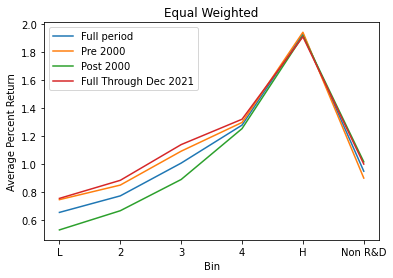

In [36]:
equal_monthly_returns, equal_stocks_w_bins = get_monthly_returns(firms, stocks, value_weighted=False)
equal_monthly_returns = get_excess_returns(equal_monthly_returns, fama_french)

equal_results = get_results(equal_monthly_returns)
display(equal_results)
equal_results.T.plot(ylabel="Average Percent Return", xlabel="Bin", title="Equal Weighted")
run_regressions_and_sharpe(fama_french, equal_monthly_returns)

,L,2,3,4,H,Non R&D
Full period,0.608,0.782,0.765,1.042,1.162,0.653
Pre 2000,1.034,1.190,1.058,1.244,1.239,0.925
Post 2000,0.025,0.227,0.368,0.766,1.057,0.280
Full Through Dec 2021,0.706,0.988,0.936,1.252,1.333,0.732


CAPM: 
alpha:  0.35
t-stat:  1.211

Fama French: 
alpha:  0.09
t-stat:  0.345

Sharpe ratio:  0.337


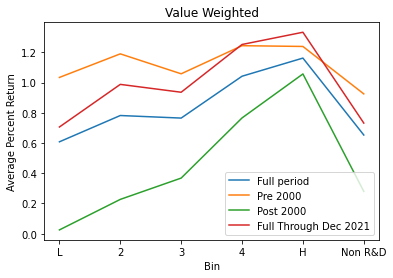

In [37]:
value_monthly_returns, value_stocks_w_bins = get_monthly_returns(firms, stocks, value_weighted=True)
value_monthly_returns = get_excess_returns(value_monthly_returns, fama_french)

value_results = get_results(value_monthly_returns)
display(value_results)
value_results.T.plot(ylabel="Average Percent Return", xlabel="Bin", title="Value Weighted")
run_regressions_and_sharpe(fama_french, value_monthly_returns)

,L,2,3,4,H,Non R&D
Full period,0.533,0.648,0.962,1.174,1.693,0.854
Pre 2000,0.536,0.718,1.016,1.140,1.459,0.724
Post 2000,0.528,0.554,0.888,1.219,2.011,1.030
Full Through Dec 2021,0.637,0.800,1.114,1.347,1.722,0.924


CAPM: 
alpha:  0.96
t-stat:  3.226

Fama French: 
alpha:  0.97
t-stat:  3.556

Sharpe ratio:  0.69


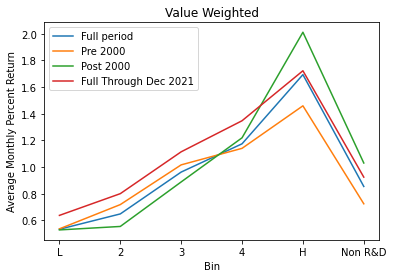

In [38]:
value_wo_1000_monthly_returns, value_wo_1000_stocks_w_bins = get_monthly_returns(firms_wo_1000, stocks, value_weighted=True)
value_wo_1000_monthly_returns = get_excess_returns(value_wo_1000_monthly_returns, fama_french)

value_wo_1000_results = get_results(value_wo_1000_monthly_returns)
display(value_wo_1000_results)
value_wo_1000_results.T.plot(ylabel="Average Monthly Percent Return", xlabel="Bin", title="Value Weighted")
run_regressions_and_sharpe(fama_french, value_wo_1000_monthly_returns)

In [19]:
# Average Market Capitalization

,datadate,bins,stock return,Date,RF,Excess Returns
0,1982-04-30,2,0.046149,1982-04-30,0.0113,3.484883
1,1982-04-30,3,0.072610,1982-04-30,0.0113,6.131010
2,1982-04-30,4,0.052045,1982-04-30,0.0113,4.074495
3,1982-04-30,H,0.053440,1982-04-30,0.0113,4.213984
4,1982-04-30,L,0.062299,1982-04-30,0.0113,5.099868
...,...,...,...,...,...,...
2857,2021-12-31,3,0.011604,2021-12-31,0.0001,1.150447
2858,2021-12-31,4,-0.008343,2021-12-31,0.0001,-0.844348
2859,2021-12-31,H,-0.065388,2021-12-31,0.0001,-6.548757
2860,2021-12-31,L,0.011332,2021-12-31,0.0001,1.123175


In [232]:
def get_avg_stat(stocks_w_bins, stat, plot = True):
    
    if stat == "Turnover":
        stocks_w_bins['Turnover'] = stocks_w_bins['VOL']/stocks_w_bins['SHROUT']
     

    
    first_period = pd.Timestamp(year=1981, month=7, day=1)
    mid_period = pd.Timestamp(year=1999, month=12, day=31)
    last_period = pd.Timestamp(year=2012, month=12, day=31)
    extra_period = pd.Timestamp(year=2021, month=12, day=31)

    order = ["L", "2", "3", "4", "H", "Non R&D"]

    full_period = stocks_w_bins[(stocks_w_bins["datadate"] >= first_period) & (stocks_w_bins["datadate"] <= last_period)].groupby("bins")[stat].mean()[order]
    pre_2000 = stocks_w_bins[(stocks_w_bins["datadate"] >= first_period) & (stocks_w_bins["datadate"] <= mid_period)].groupby("bins")[stat].mean()[order]
    post_2000 = stocks_w_bins[(stocks_w_bins["datadate"] > mid_period) & (stocks_w_bins["datadate"] <= last_period)].groupby("bins")[stat].mean()[order]
    extra = stocks_w_bins[(stocks_w_bins["datadate"] >= first_period) & (stocks_w_bins["datadate"] <= extra_period)].groupby("bins")[stat].mean()[order]


    results = pd.DataFrame({c: pd.Series(dtype="float") for c in order})

    results.loc[len(results.index)] = full_period
    results.loc[len(results.index)] = pre_2000
    results.loc[len(results.index)] = post_2000
    results.loc[len(results.index)] = extra
    
    ax_max = max(full_period.max(), pre_2000.max(), post_2000.max(), extra.max())

    ax_max = ax_max * 1.05

    if plot:
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,9))
        fig.suptitle('Average ' + stat, fontsize=14)
        ax[0,0].bar(order,full_period[order])
        ax[0,0].set_ylim(0,ax_max)
        ax[0,0].set_title('Full period')
       
        ax[0,1].bar(order,pre_2000[order])
        ax[0,1].set_ylim(0,ax_max)
        ax[0,1].set_title('Pre 2000')

        ax[1,0].bar(order,post_2000[order])
        ax[1,0].set_ylim(0,ax_max)
        ax[1,0].set_title('Post 2000')

        ax[1,1].bar(order,extra[order])
        ax[1,1].set_ylim(0,ax_max)
        ax[1,1].set_title('Full Through Dec 2021')

        plt.show()



    results.index = ["Full period", "Pre 2000", "Post 2000", "Full Through Dec 2021"]
    return results

In [233]:
def get_factor_betas(monthly_return, fama_french):
     return_betas = pd.merge(monthly_return, fama_french, on="Date")
     order = ["L", "2", "3", "4", "H", "Non R&D"]

     first_period = pd.Timestamp(year=1981, month=7, day=1)
     mid_period = pd.Timestamp(year=1999, month=12, day=31)
     last_period = pd.Timestamp(year=2012, month=12, day=31)
     extra_period = pd.Timestamp(year=2021, month=12, day=31)

     periods = [(first_period,last_period), (first_period,mid_period), (mid_period, last_period), (first_period, extra_period)]

     beta_dfs = []

     for period in periods:
          bin_data = return_betas[(return_betas["Date"] >= period[0]) & (return_betas["Date"] <= period[1])]
          bin_betas = {}
          for bin in order:
               data_bin = bin_data[bin_data['bins']==bin]
               X = data_bin[['Mkt-RF','SMB','HML']] * 100
               X = sm.add_constant(X)
               y = data_bin['Excess Returns']
               model = sm.OLS(y, X)
               results = model.fit()
               bin_betas[bin] = list(results.params[1:])

          temp = pd.DataFrame(bin_betas).T
          temp.columns = ["Market", "Size", "Value"]
          
          beta_dfs.append(temp)

     return beta_dfs


In [234]:
def plot_factors(period_betas, factor):
    order = ["L", "2", "3", "4", "H", "Non R&D"]
    full_period_betas, pre_2000_betas, post_2000_betas, extended_betas = period_betas
   
    full_period = full_period_betas[factor]
    pre_2000 = pre_2000_betas[factor]
    post_2000 = post_2000_betas[factor]
    extra = extended_betas[factor]

    ax_max = max(full_period.max(), pre_2000.max(), post_2000.max(), extra.max()) + .1

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,9))
    fig.suptitle('Average ' + factor, fontsize=14)
    ax[0,0].bar(order,full_period[order])
    ax[0,0].set_ylim(top = ax_max)
    ax[0,0].set_title('Full period')

    ax[0,1].bar(order,pre_2000[order])
    ax[0,1].set_ylim(top = ax_max)
    ax[0,1].set_title('Pre 2000')

    ax[1,0].bar(order,post_2000[order])
    ax[1,0].set_ylim(top = ax_max)
    ax[1,0].set_title('Post 2000')

    ax[1,1].bar(order,extra[order])
    ax[1,1].set_ylim(top = ax_max)
    ax[1,1].set_title('Full Through Dec 2021')

    plt.show()

    factor_df = pd.DataFrame([full_period, pre_2000, post_2000, extra], columns=order)
    factor_df.index = ['Full period', 'Pre 2000', 'Post 2000', 'Full Through Dec 2021']
    #factor_df.append([full_period, pre_2000, post_2000, extra],ignore_index=True)
    return factor_df



In [235]:
# Equal Weighted

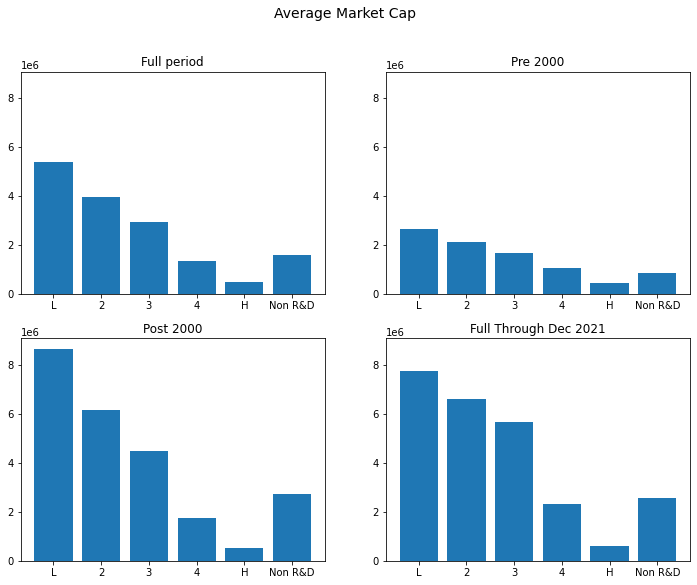

,L,2,3,4,H,Non R&D
Full period,5.398625e+06,3.945806e+06,2.950661e+06,1.357994e+06,488437.701032,1.591447e+06
Pre 2000,2.664997e+06,2.102096e+06,1.660521e+06,1.050055e+06,461602.217231,8.355482e+05
Post 2000,8.641034e+06,6.143346e+06,4.497291e+06,1.731255e+06,521781.990049,2.707038e+06
Full Through Dec 2021,7.732843e+06,6.594533e+06,5.677416e+06,2.318311e+06,584644.028785,2.567696e+06


In [236]:
get_avg_stat(equal_stocks_w_bins, "Market Cap")

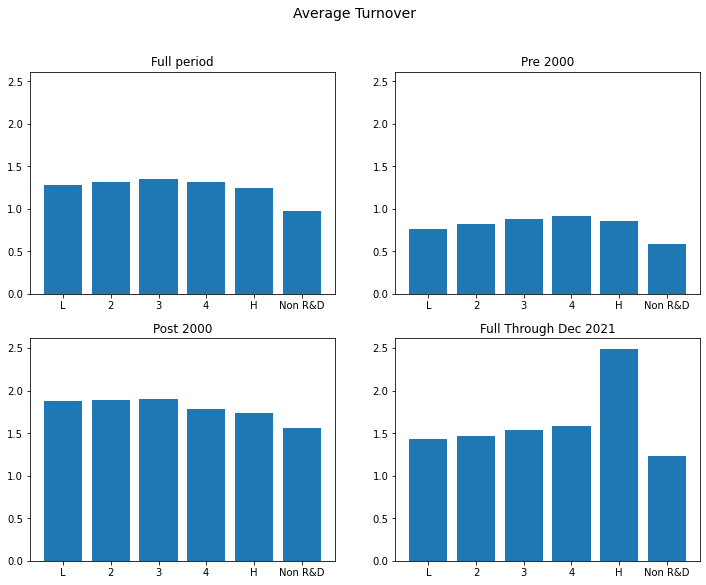

,L,2,3,4,H,Non R&D
Full period,1.277066,1.310826,1.346736,1.309897,1.248688,0.979638
Pre 2000,0.767363,0.818582,0.882189,0.911477,0.852719,0.582155
Post 2000,1.874528,1.892199,1.898646,1.788069,1.735740,1.559607
Full Through Dec 2021,1.427620,1.471898,1.538293,1.587353,2.488058,1.228691


In [237]:
get_avg_stat(equal_stocks_w_bins, "Turnover")

In [238]:
equal_period_betas = get_factor_betas(equal_monthly_returns, fama_french)
full_period_betas, pre_2000_betas, post_2000_betas, extended_betas = equal_period_betas

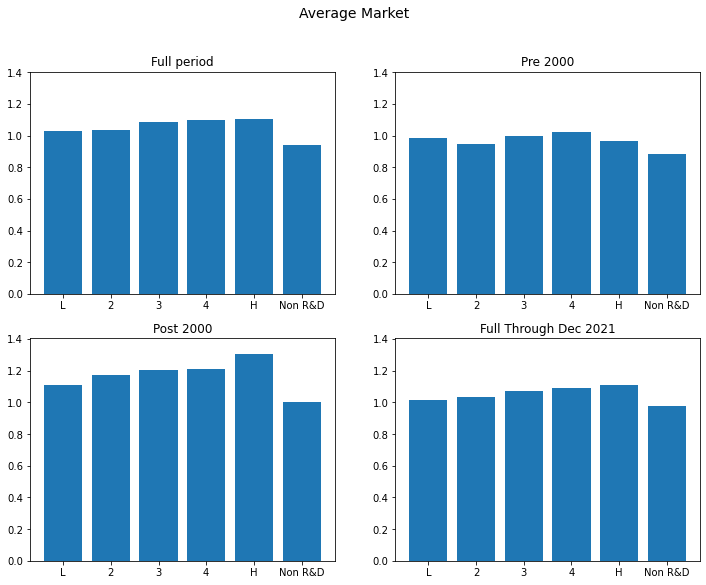

,L,2,3,4,H,Non R&D
Full period,1.028396,1.032717,1.087880,1.095702,1.106124,0.939402
Pre 2000,0.986013,0.944679,1.000002,1.024745,0.962668,0.881629
Post 2000,1.111739,1.172451,1.204433,1.209661,1.303710,1.002661
Full Through Dec 2021,1.016392,1.034236,1.074751,1.088287,1.107250,0.978940


In [239]:
plot_factors(equal_period_betas, "Market")

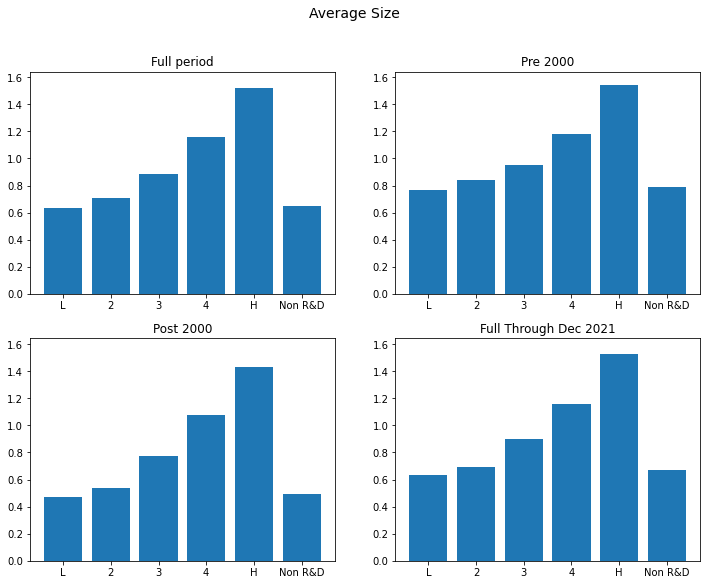

,L,2,3,4,H,Non R&D
Full period,0.631586,0.710271,0.885671,1.156913,1.520050,0.649238
Pre 2000,0.769934,0.841898,0.954384,1.184392,1.541872,0.789239
Post 2000,0.470507,0.535968,0.773806,1.078115,1.430971,0.495802
Full Through Dec 2021,0.632985,0.690474,0.898660,1.156311,1.523830,0.670127


In [240]:
plot_factors(equal_period_betas, "Size")

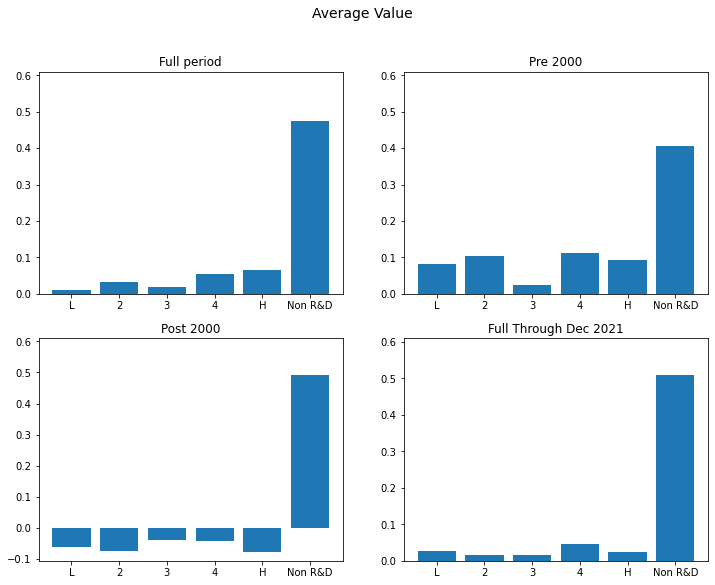

,L,2,3,4,H,Non R&D
Full period,0.010539,0.032780,0.019991,0.054421,0.065761,0.474331
Pre 2000,0.082529,0.103188,0.023374,0.111865,0.094105,0.406496
Post 2000,-0.062863,-0.075780,-0.041146,-0.041544,-0.078236,0.490438
Full Through Dec 2021,0.025610,0.015937,0.014578,0.045958,0.023085,0.509697


In [241]:
plot_factors(equal_period_betas, "Value")

In [242]:
# Value weighted

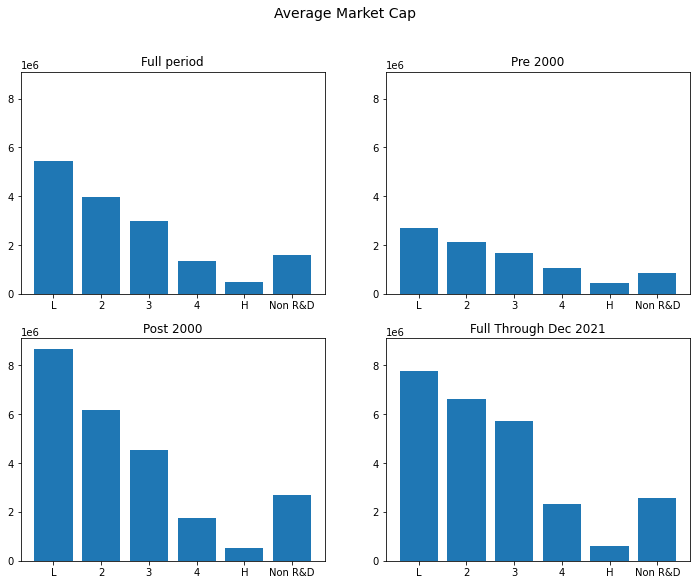

,L,2,3,4,H,Non R&D
Full period,5.436402e+06,3.971594e+06,2.972380e+06,1.368207e+06,492265.726143,1.601707e+06
Pre 2000,2.689952e+06,2.118399e+06,1.674699e+06,1.060182e+06,465648.844959,8.423644e+05
Post 2000,8.674216e+06,6.168319e+06,4.519852e+06,1.739469e+06,525213.825088,2.715163e+06
Full Through Dec 2021,7.777524e+06,6.631663e+06,5.711955e+06,2.335161e+06,588531.300396,2.583552e+06


In [243]:
get_avg_stat(value_stocks_w_bins, "Market Cap")

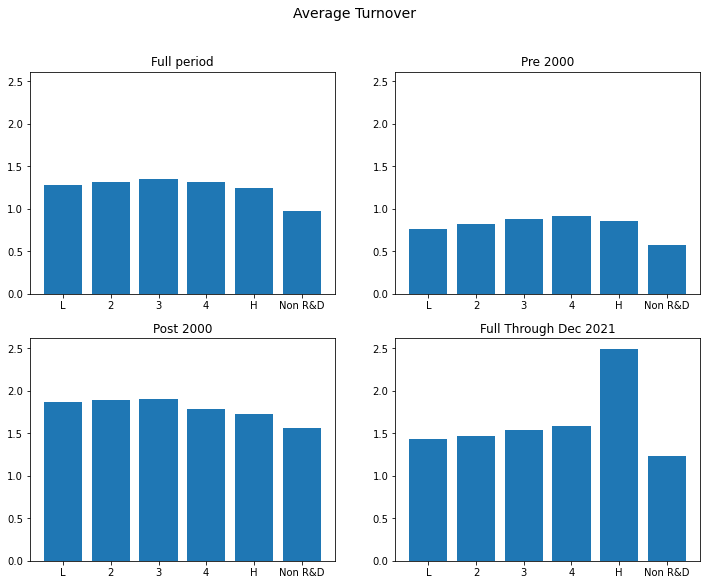

,L,2,3,4,H,Non R&D
Full period,1.275865,1.310481,1.346102,1.311062,1.247479,0.980355
Pre 2000,0.764924,0.817513,0.880628,0.910709,0.853680,0.581161
Post 2000,1.872066,1.890218,1.896843,1.789471,1.730675,1.559947
Full Through Dec 2021,1.427045,1.471817,1.538203,1.588682,2.489557,1.230334


In [244]:
get_avg_stat(value_stocks_w_bins, "Turnover")

In [245]:
value_period_betas = get_factor_betas(value_monthly_returns, fama_french)
full_period_betas, pre_2000_betas, post_2000_betas, extended_betas = value_period_betas

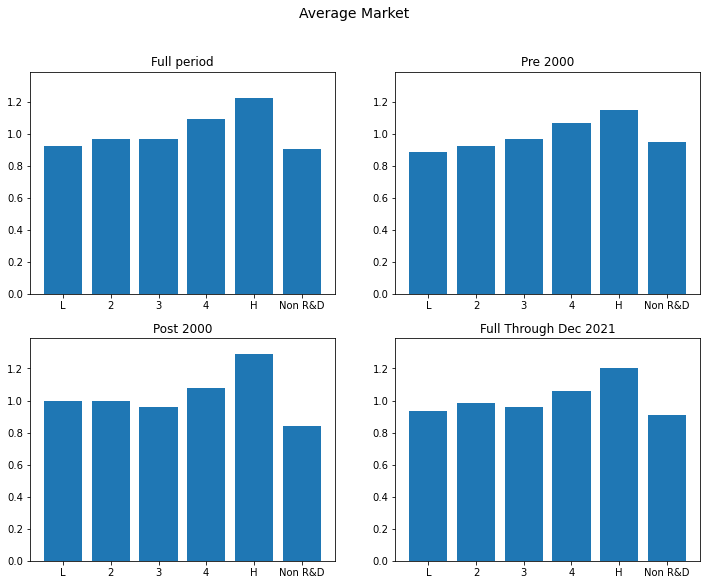

,L,2,3,4,H,Non R&D
Full period,0.920899,0.964483,0.968382,1.089106,1.224227,0.903380
Pre 2000,0.887101,0.924791,0.969054,1.064118,1.146848,0.949306
Post 2000,0.995797,0.994667,0.961249,1.075461,1.287456,0.842936
Full Through Dec 2021,0.936357,0.983009,0.961662,1.059983,1.202962,0.909996


In [246]:
plot_factors(value_period_betas, "Market")

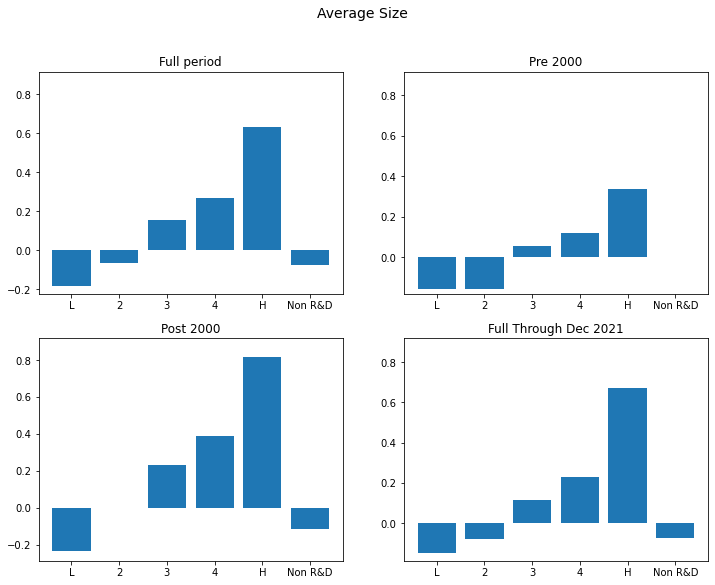

,L,2,3,4,H,Non R&D
Full period,-0.183040,-0.067052,0.154989,0.267715,0.634436,-0.073923
Pre 2000,-0.156163,-0.154011,0.054648,0.121087,0.338336,0.001115
Post 2000,-0.234889,-0.003593,0.230298,0.388213,0.817704,-0.114775
Full Through Dec 2021,-0.145608,-0.077074,0.114856,0.229456,0.669159,-0.072561


In [247]:
plot_factors(value_period_betas, "Size")

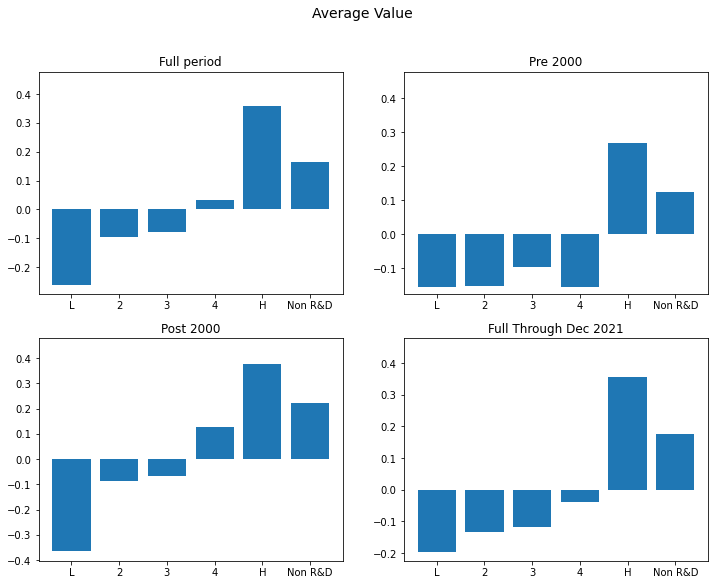

,L,2,3,4,H,Non R&D
Full period,-0.262035,-0.094271,-0.077807,0.032994,0.359251,0.162901
Pre 2000,-0.154804,-0.153908,-0.095594,-0.154200,0.266689,0.124372
Post 2000,-0.365367,-0.087742,-0.064979,0.127706,0.378122,0.222323
Full Through Dec 2021,-0.196656,-0.133021,-0.115955,-0.037412,0.355229,0.177794


In [248]:
plot_factors(value_period_betas, "Value")

In [249]:
# Value without largest 1000

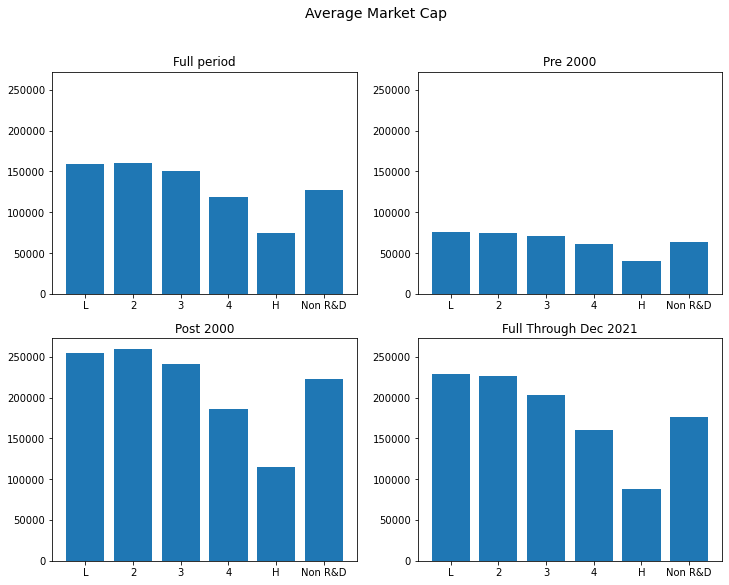

,L,2,3,4,H,Non R&D
Full period,159128.342776,160890.971612,150476.559708,118394.393015,74230.016380,127134.108930
Pre 2000,75456.167602,74924.364117,71493.286662,60580.862244,40230.906846,63105.667357
Post 2000,254131.343174,259449.955346,241446.120244,185523.936834,115070.388736,222177.307842
Full Through Dec 2021,229110.024107,226598.910456,202964.842751,160748.763805,88264.370472,175984.321040


In [250]:
get_avg_stat(value_wo_1000_stocks_w_bins, "Market Cap")

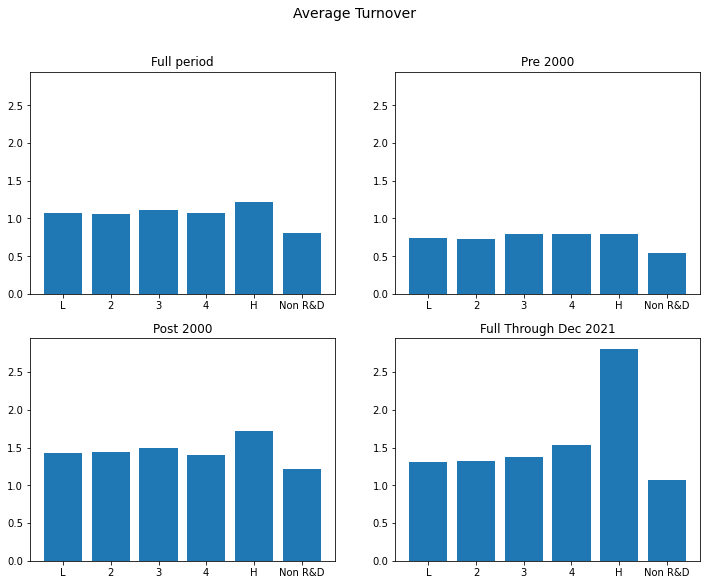

,L,2,3,4,H,Non R&D
Full period,1.065468,1.058800,1.117171,1.076679,1.219703,0.812153
Pre 2000,0.741073,0.722854,0.787763,0.799914,0.800187,0.538329
Post 2000,1.429307,1.439738,1.492186,1.394728,1.718189,1.213306
Full Through Dec 2021,1.312269,1.319139,1.373333,1.535909,2.804543,1.068340


In [251]:
get_avg_stat(value_wo_1000_stocks_w_bins, "Turnover")

In [252]:
value_wo_1000_period_betas = get_factor_betas(value_wo_1000_monthly_returns, fama_french)
full_period_betas, pre_2000_betas, post_2000_betas, extended_betas = value_wo_1000_period_betas

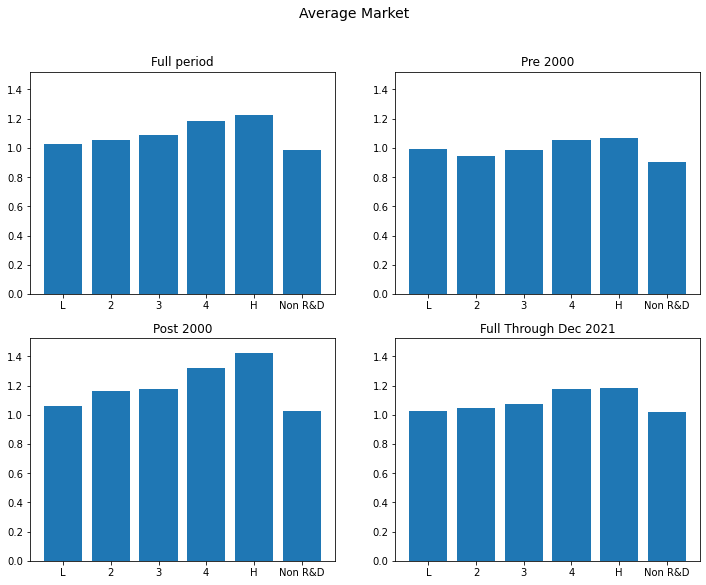

,L,2,3,4,H,Non R&D
Full period,1.025345,1.050919,1.088898,1.186804,1.227167,0.984127
Pre 2000,0.990329,0.947057,0.987288,1.050825,1.064817,0.905002
Post 2000,1.061859,1.163503,1.174843,1.321177,1.422747,1.026103
Full Through Dec 2021,1.025887,1.043633,1.073555,1.175895,1.181517,1.020955


In [253]:
plot_factors(value_wo_1000_period_betas, "Market")

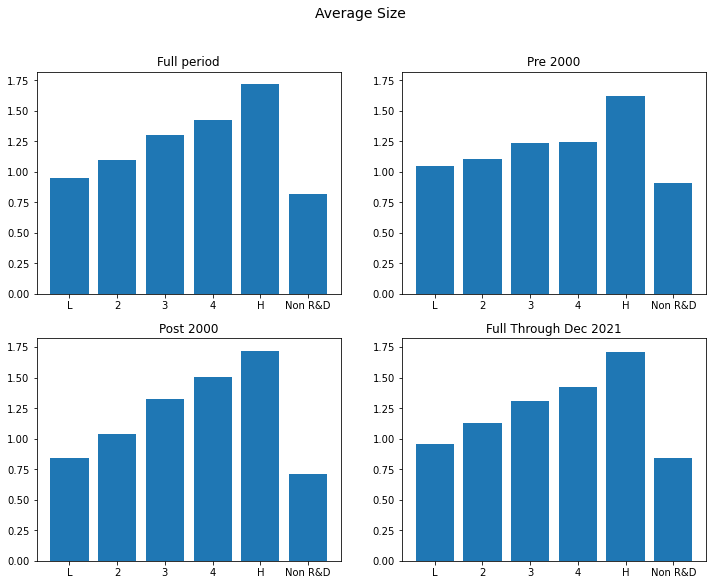

,L,2,3,4,H,Non R&D
Full period,0.946929,1.098351,1.305221,1.423559,1.720652,0.817083
Pre 2000,1.049743,1.102998,1.232769,1.245994,1.621676,0.907295
Post 2000,0.839998,1.040926,1.327474,1.504814,1.715138,0.710057
Full Through Dec 2021,0.959392,1.126633,1.309135,1.424313,1.707082,0.841224


In [254]:
plot_factors(value_wo_1000_period_betas, "Size")

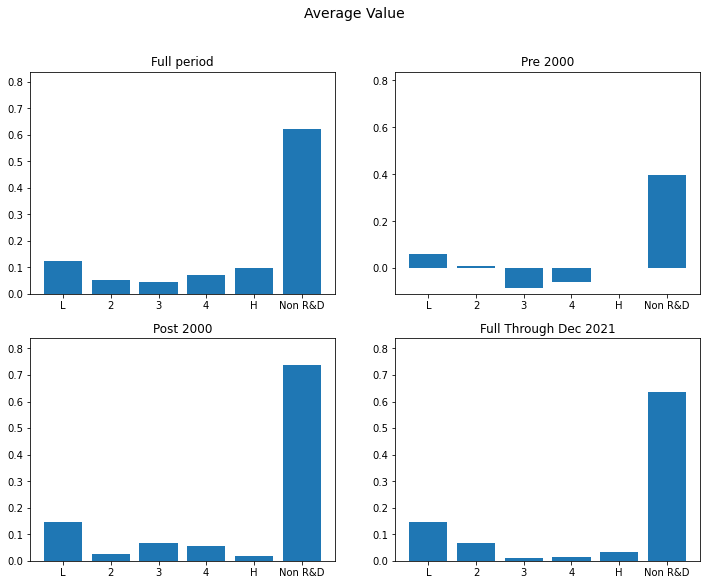

,L,2,3,4,H,Non R&D
Full period,0.125559,0.053287,0.045277,0.070735,0.099514,0.620961
Pre 2000,0.060309,0.006769,-0.086380,-0.061619,-0.000898,0.398615
Post 2000,0.146942,0.025294,0.068084,0.055855,0.019341,0.737638
Full Through Dec 2021,0.145682,0.068412,0.010390,0.015503,0.034308,0.636854


In [255]:
plot_factors(value_wo_1000_period_betas, "Value")